In [147]:
import functions_exp_kernel as fn
import importlib
importlib.reload(fn)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import differential_evolution
import scipy.linalg
from sklearn.covariance import MinCovDet
from scipy.spatial.distance import mahalanobis
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import r2_score
import time
import random
np.random.seed(0)
random.seed(0)


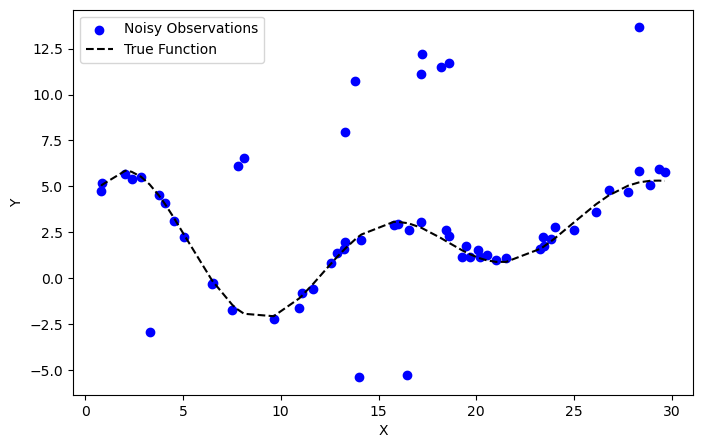

In [261]:
def ground_truth_function(x):
    return np.sin(0.5 * x) * (10 * np.log(x + 2) / x) + (x ** 2) / 200

np.random.seed(0)  
n = 60
X = np.random.uniform(0.25, 30, n)  
X = np.sort(X)
noise_variance = 0.1
noise = np.random.normal(0, np.sqrt(noise_variance), X.shape)
Y = ground_truth_function(X) + noise

#---------------------------5% Contamination -------------------------------
# Outlier contamination
outlier_ratio = 0.05
num_outliers = int(outlier_ratio * len(Y))

# Randomly select indices for outliers
outlier_indices = np.random.choice(len(Y), num_outliers, replace=False)

# Compute outlier magnitude (random value in [3σ, 5σ])
y_std = np.std(Y)
outlier_magnitude = np.random.uniform(3 * y_std, 5 * y_std, num_outliers)

# Randomly add or subtract outlier magnitude
outlier_sign = np.random.choice([-1, 1], num_outliers)

Y_5 = Y.copy() 
Y_5[outlier_indices] += outlier_sign * outlier_magnitude  # Apply perturbation

#----------------------------------------------------------------------------


#---------------------------10% Contamination -------------------------------
# Outlier contamination
outlier_ratio = 0.1
num_outliers = int(outlier_ratio * len(Y))

# Randomly select indices for outliers
outlier_indices = np.random.choice(len(Y), num_outliers, replace=False)

# Compute outlier magnitude (random value in [3σ, 5σ])
y_std = np.std(Y)
outlier_magnitude = np.random.uniform(3 * y_std, 5 * y_std, num_outliers)

# Randomly add or subtract outlier magnitude
outlier_sign = np.random.choice([-1, 1], num_outliers)

Y_10 = Y.copy() 
Y_10[outlier_indices] += outlier_sign * outlier_magnitude  # Apply perturbation

#----------------------------------------------------------------------------

#---------------------------15% Contamination -------------------------------
# Outlier contamination
outlier_ratio = 0.15
num_outliers = int(outlier_ratio * len(Y))

# Randomly select indices for outliers
outlier_indices = np.random.choice(len(Y), num_outliers, replace=False)

# Compute outlier magnitude (random value in [3σ, 5σ])
y_std = np.std(Y)
outlier_magnitude = np.random.uniform(3 * y_std, 5 * y_std, num_outliers)

# Randomly add or subtract outlier magnitude
outlier_sign = np.random.choice([-1, 1], num_outliers)

Y_15 = Y.copy() 
Y_15[outlier_indices] += outlier_sign * outlier_magnitude  # Apply perturbation

#----------------------------------------------------------------------------


#---------------------------20% Contamination -------------------------------
# Outlier contamination
outlier_ratio = 0.2
num_outliers = int(outlier_ratio * len(Y))

# Randomly select indices for outliers
outlier_indices = np.random.choice(len(Y), num_outliers, replace=False)

# Compute outlier magnitude (random value in [3σ, 5σ])
y_std = np.std(Y)
outlier_magnitude = np.random.uniform(3 * y_std, 5 * y_std, num_outliers)

# Randomly add or subtract outlier magnitude
outlier_sign = np.random.choice([-1, 1], num_outliers)

Y_20 = Y.copy() 
Y_20[outlier_indices] += outlier_sign * outlier_magnitude  # Apply perturbation

#----------------------------------------------------------------------------




X = X.reshape(-1, 1)
Y = Y.reshape(-1, 1)

plt.figure(figsize=(8, 5))
plt.scatter(X, Y_20, color='blue', label="Noisy Observations")
plt.plot(X, ground_truth_function(X), color='black', linestyle="dashed", label="True Function")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
#plt.savefig("plot_synthetic_data.pdf", format="pdf", bbox_inches="tight")

In [125]:
theta_SGP, sigma_SGP = fn.optimize_hyperparameters(X, Y)
print(f"theta : {theta_SGP}, sigma2: {sigma_SGP**2}")

theta : 0.11467132637745425, sigma2: 0.08428491017224081


In [127]:
w_D = fn.compute_robust_weights(X, Y, gamma = 0.005, r = 0.25, s = 5, eta = 0.5)

theta_RWGP, sigma_RWGP = fn.optimize_hyperparameters_weighted(X, Y, w_D)
print(f"theta : {theta_RWGP}, sigma2: {sigma_RWGP**2}")

theta : 0.10848226446538631, sigma2: 0.03434822046803165


In [129]:
depth_opt_K = np.zeros((15, 2))
for k in range(5,20):
    nbrs = NearestNeighbors(n_neighbors = k, algorithm = 'auto').fit(X)
    distances, indices = nbrs.kneighbors(X)
    depth = np.zeros(len(X))
    for i in range(len(X)):
        depth[i] = fn.mahalanobis_depth(Y[indices[i][1:]], Y[indices[i][0]]).item()
    gamma, lamda = fn.optimize_weight_parameters(X, Y, depth)
    weight_depth_opt = fn.weight(1-depth, gamma, lamda)
    theta, sigma = fn.optimize_hyperparameters_weighted(X, Y,  weight_depth_opt)
    params = (theta, sigma) 
    nll_depth_opt = fn.negative_log_marginal_likelihood_weighted(params, X, Y, weight_depth_opt)
    depth_opt_K[k-5] = [k, nll_depth_opt]

depth_opt_K_sort = depth_opt_K[depth_opt_K[:,1].argsort()]

k = int(depth_opt_K_sort[0, 0])
nbrs = NearestNeighbors(n_neighbors = k, algorithm = 'auto').fit(X)
distances, indices = nbrs.kneighbors(X)
depth = np.zeros(len(X))
for i in range(len(X)):
    depth[i] = fn.mahalanobis_depth(Y[indices[i][1:]], Y[indices[i][0]]).item()
gamma, lamda = fn.optimize_weight_parameters(X, Y, depth)
weight_depth_opt = fn.weight(1-depth, gamma, lamda)
print(f"k : {k}, gamma: {gamma}, lamda: {lamda}")
theta_DWGP, sigma_DWGP = fn.optimize_hyperparameters_weighted(X, Y, weight_depth_opt)

print(f"theta : {theta_DWGP}, sigma2: {sigma_DWGP**2}")

k : 6, gamma: 0.048174643227470754, lamda: 8.888667495123187
theta : 0.10998185389542103, sigma2: 0.013994200438168476


In [215]:
start_time = time.time()
num_repeats = 30
num_splits= 10

rmse_results_DWGP = np.zeros((num_repeats, num_splits))  
rmse_results_RWGP = np.zeros((num_repeats, num_splits))  
rmse_results_SGP = np.zeros((num_repeats, num_splits)) 

Y_clean = Y.copy() 

for repeat in range(num_repeats):
    
    kf = KFold(n_splits=num_splits, shuffle=True, random_state=repeat)  # Shuffle in each repeat
    
    fold_idx = 0
    
    for train_index, test_index in kf.split(X):
        
        X_train, X_test = X[train_index], X[test_index]
        
        y_train, y_test = Y[train_index], Y[test_index]

        y_test_true = Y_clean[test_index]
        
        X_train = X_train.reshape(-1, 1)

        y_train = y_train.reshape(-1, 1)
        
        X_test = X_test.reshape(-1, 1) 

        #--------------------DWGP----------------------
        nbrs = NearestNeighbors(n_neighbors = k, algorithm = 'auto').fit(X_train)
        distances, indices = nbrs.kneighbors(X_train)

        depth = np.zeros(len(X_train))
        for i in range(len(X_train)):
            depth[i] = fn.mahalanobis_depth(y_train[indices[i][1:]], y_train[indices[i][0]]).item()
        gamma, lamda = fn.optimize_weight_parameters(X_train, y_train, depth)
        weight_depth_opt = fn.weight(1-depth, gamma, lamda)

        # GP regression prediction
        mu_s_DWGP, _ = fn.gp_regression_weighted(X_train, y_train, X_test, theta_DWGP, sigma_DWGP, weight_depth_opt)
        
        # Compute RMSE
        rmse_DWGP = np.sqrt(mean_squared_error(y_test_true, mu_s_DWGP))
        
        rmse_results_DWGP[repeat, fold_idx] = rmse_DWGP
        #--------------------DWGP----------------------

        #--------------------RWGP----------------------
        w_D = fn.compute_robust_weights(X_train, y_train, gamma = 0.005, r=0.25, s=5, eta = 0.5)
        
        mu_s_RWGP, _ = fn.gp_regression_weighted(X_train, y_train, X_test, theta_RWGP, sigma_RWGP, w_D)
        
        # Compute RMSE
        rmse_RWGP = np.sqrt(mean_squared_error(y_test_true, mu_s_RWGP))
        
        rmse_results_RWGP[repeat, fold_idx] = rmse_RWGP
        #--------------------RWGP----------------------

        #--------------------SGP----------------------
        mu_s_SGP, _ = fn.gp_regression(X_train, y_train, X_test, theta_SGP, sigma_SGP)
        
        # Compute RMSE
        rmse_SGP = np.sqrt(mean_squared_error(y_test_true, mu_s_SGP))
        rmse_results_SGP[repeat, fold_idx] = rmse_SGP
        #--------------------SGP----------------------
        
        fold_idx += 1
        
rmse_DWGP = np.mean(rmse_results_DWGP, axis = 1)
rmse_RWGP = np.mean(rmse_results_RWGP, axis = 1)
rmse_SGP = np.mean(rmse_results_SGP, axis = 1)

mean_rmse_DWGP = np.mean(rmse_results_DWGP)
std_rmse_DWGP = np.std(rmse_results_DWGP)

mean_rmse_RWGP = np.mean(rmse_results_RWGP)
std_rmse_RWGP = np.std(rmse_results_RWGP)

mean_rmse_SGP = np.mean(rmse_results_SGP)
std_rmse_SGP = np.std(rmse_results_SGP)


end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.4f} seconds")

Execution time: 627.6451 seconds


In [335]:
print(f"Average RMSE DWGP: {np.mean(rmse_DWGP):.4f}")
print(f"Average RMSE RWGP: {np.mean(rmse_RWGP):.4f}")
print(f"Average RMSE SGP: {np.mean(rmse_SGP):.4f}")

Average RMSE DWGP: 0.3246
Average RMSE RWGP: 0.3170
Average RMSE SGP: 0.3132


In [337]:
print(f"Average Error Difference between DWGP and RWGP: {np.mean(rmse_DWGP)-np.mean(rmse_RWGP):.4f}")
print(f"Average Error Difference between DWGP and SGP: {np.mean(rmse_DWGP)-np.mean(rmse_SGP):.4f}")

Average Error Difference between DWGP and RWGP: 0.0076
Average Error Difference between DWGP and SGP: 0.0115


In [339]:
from scipy import stats
t_stat, p_value = stats.ttest_rel(rmse_DWGP, rmse_RWGP)
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: 3.559295861801321
P-value: 0.0013039519578895026


In [341]:
t_stat, p_value = stats.ttest_rel(rmse_DWGP, rmse_SGP)
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: 4.74438341744795
P-value: 5.159912499217043e-05


In [281]:
start_time = time.time()
num_repeats = 30
num_splits= 10

rmse_results_DWGP_5 = np.zeros((num_repeats, num_splits))  
rmse_results_RWGP_5 = np.zeros((num_repeats, num_splits))  
rmse_results_SGP_5 = np.zeros((num_repeats, num_splits)) 

Y_clean = Y.copy() 

for repeat in range(num_repeats):
    
    kf = KFold(n_splits=num_splits, shuffle=True, random_state=repeat)  # Shuffle in each repeat
    
    fold_idx = 0
    
    for train_index, test_index in kf.split(X):
        
        X_train, X_test = X[train_index], X[test_index]
        
        y_train, y_test = Y_5[train_index], Y_5[test_index]

        y_test_true = Y_clean[test_index]
        
        X_train = X_train.reshape(-1, 1)

        y_train = y_train.reshape(-1, 1)
        
        X_test = X_test.reshape(-1, 1) 

        #--------------------DWGP----------------------
        nbrs = NearestNeighbors(n_neighbors = k, algorithm = 'auto').fit(X_train)
        distances, indices = nbrs.kneighbors(X_train)

        depth = np.zeros(len(X_train))
        for i in range(len(X_train)):
            depth[i] = fn.mahalanobis_depth(y_train[indices[i][1:]], y_train[indices[i][0]]).item()
        gamma, lamda = fn.optimize_weight_parameters(X_train, y_train, depth)
        weight_depth_opt = fn.weight(1-depth, gamma, lamda)

        # GP regression prediction
        mu_s_DWGP_5, _ = fn.gp_regression_weighted(X_train, y_train, X_test, theta_DWGP, sigma_DWGP, weight_depth_opt)
        
        # Compute RMSE
        rmse_DWGP_5 = np.sqrt(mean_squared_error(y_test_true, mu_s_DWGP_5))
        
        rmse_results_DWGP_5[repeat, fold_idx] = rmse_DWGP_5
        #--------------------DWGP----------------------

        #--------------------RWGP----------------------
        w_D = fn.compute_robust_weights(X_train, y_train, gamma = 0.005, r=0.25, s=5, eta = 0.5)
        
        mu_s_RWGP_5, _ = fn.gp_regression_weighted(X_train, y_train, X_test, theta_RWGP, sigma_RWGP, w_D)
        
        # Compute RMSE
        rmse_RWGP_5 = np.sqrt(mean_squared_error(y_test_true, mu_s_RWGP_5))
        
        rmse_results_RWGP_5[repeat, fold_idx] = rmse_RWGP_5
        #--------------------RWGP----------------------

        #--------------------SGP----------------------
        mu_s_SGP_5, _ = fn.gp_regression(X_train, y_train, X_test, theta_SGP, sigma_SGP)
        
        # Compute RMSE
        rmse_SGP_5 = np.sqrt(mean_squared_error(y_test_true, mu_s_SGP_5))
        rmse_results_SGP_5[repeat, fold_idx] = rmse_SGP_5
        #--------------------SGP----------------------
        
        fold_idx += 1
        
rmse_DWGP_5 = np.mean(rmse_results_DWGP_5, axis = 1)
rmse_RWGP_5 = np.mean(rmse_results_RWGP_5, axis = 1)
rmse_SGP_5 = np.mean(rmse_results_SGP_5, axis = 1)

mean_rmse_DWGP_5 = np.mean(rmse_results_DWGP_5)
std_rmse_DWGP_5 = np.std(rmse_results_DWGP_5)

mean_rmse_RWGP_5 = np.mean(rmse_results_RWGP_5)
std_rmse_RWGP_5 = np.std(rmse_results_RWGP_5)

mean_rmse_SGP_5 = np.mean(rmse_results_SGP_5)
std_rmse_SGP_5 = np.std(rmse_results_SGP_5)


end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.4f} seconds")

Execution time: 509.3237 seconds


In [329]:
print(f"Average RMSE DWGP_5: {np.mean(rmse_DWGP_5):.4f}")
print(f"Average RMSE RWGP_5: {np.mean(rmse_RWGP_5):.4f}")
print(f"Average RMSE SGP_5: {np.mean(rmse_SGP_5):.4f}")

Average RMSE DWGP_5: 0.3554
Average RMSE RWGP_5: 0.4813
Average RMSE SGP_5: 0.7839


In [333]:
print(f"Average Error Difference between DWGP_5 and RWGP_5: {np.mean(rmse_DWGP_5)-np.mean(rmse_RWGP_5):.4f}")
print(f"Average Error Difference between DWGP_5 and SGP_5: {np.mean(rmse_DWGP_5)-np.mean(rmse_SGP_5):.4f}")

Average Error Difference between DWGP_5 and RWGP_5: -0.1259
Average Error Difference between DWGP_5 and SGP_5: -0.4284


In [343]:
from scipy import stats
t_stat, p_value = stats.ttest_rel(rmse_DWGP_5, rmse_RWGP_5)
print("T-statistic:", t_stat)
print("P-value:", p_value)


T-statistic: -6.59437731320047
P-value: 3.163280482709998e-07


In [345]:
t_stat, p_value = stats.ttest_rel(rmse_DWGP_5, rmse_SGP_5)
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -46.585314713258846
P-value: 8.159245400027094e-29


In [363]:
start_time = time.time()
num_repeats = 30
num_splits= 10

rmse_results_DWGP_10 = np.zeros((num_repeats, num_splits))  
rmse_results_RWGP_10 = np.zeros((num_repeats, num_splits))  
rmse_results_SGP_10 = np.zeros((num_repeats, num_splits)) 

Y_clean = Y.copy() 

for repeat in range(num_repeats):
    
    kf = KFold(n_splits=num_splits, shuffle=True, random_state=repeat)  # Shuffle in each repeat
    
    fold_idx = 0
    
    for train_index, test_index in kf.split(X):
        
        X_train, X_test = X[train_index], X[test_index]
        
        y_train, y_test = Y_10[train_index], Y_10[test_index]

        y_test_true = Y_clean[test_index]
        
        X_train = X_train.reshape(-1, 1)

        y_train = y_train.reshape(-1, 1)
        
        X_test = X_test.reshape(-1, 1) 

        #--------------------DWGP----------------------
        nbrs = NearestNeighbors(n_neighbors = k, algorithm = 'auto').fit(X_train)
        distances, indices = nbrs.kneighbors(X_train)

        depth = np.zeros(len(X_train))
        for i in range(len(X_train)):
            depth[i] = fn.mahalanobis_depth(y_train[indices[i][1:]], y_train[indices[i][0]]).item()
        gamma, lamda = fn.optimize_weight_parameters(X_train, y_train, depth)
        weight_depth_opt = fn.weight(1-depth, gamma, lamda)

        # GP regression prediction
        mu_s_DWGP_10, _ = fn.gp_regression_weighted(X_train, y_train, X_test, theta_DWGP, sigma_DWGP, weight_depth_opt)
        
        # Compute RMSE
        rmse_DWGP_10 = np.sqrt(mean_squared_error(y_test_true, mu_s_DWGP_10))
        
        rmse_results_DWGP_10[repeat, fold_idx] = rmse_DWGP_10
        #--------------------DWGP----------------------

        #--------------------RWGP----------------------
        w_D = fn.compute_robust_weights(X_train, y_train, gamma = 0.005, r=0.25, s=5, eta = 0.5)
        
        mu_s_RWGP_10, _ = fn.gp_regression_weighted(X_train, y_train, X_test, theta_RWGP, sigma_RWGP, w_D)
        
        # Compute RMSE
        rmse_RWGP_10 = np.sqrt(mean_squared_error(y_test_true, mu_s_RWGP_10))
        
        rmse_results_RWGP_10[repeat, fold_idx] = rmse_RWGP_10
        #--------------------RWGP----------------------

        #--------------------SGP----------------------
        mu_s_SGP_10, _ = fn.gp_regression(X_train, y_train, X_test, theta_SGP, sigma_SGP)
        
        # Compute RMSE
        rmse_SGP_10 = np.sqrt(mean_squared_error(y_test_true, mu_s_SGP_10))
        rmse_results_SGP_10[repeat, fold_idx] = rmse_SGP_10
        #--------------------SGP----------------------
        
        fold_idx += 1
        
rmse_DWGP_10 = np.mean(rmse_results_DWGP_10, axis = 1)
rmse_RWGP_10 = np.mean(rmse_results_RWGP_10, axis = 1)
rmse_SGP_10 = np.mean(rmse_results_SGP_10, axis = 1)

mean_rmse_DWGP_10 = np.mean(rmse_results_DWGP_10)
std_rmse_DWGP_10 = np.std(rmse_results_DWGP_10)

mean_rmse_RWGP_10 = np.mean(rmse_results_RWGP_10)
std_rmse_RWGP_10 = np.std(rmse_results_RWGP_10)

mean_rmse_SGP_10 = np.mean(rmse_results_SGP_10)
std_rmse_SGP_10 = np.std(rmse_results_SGP_10)


end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.4f} seconds")

Execution time: 497.1642 seconds


In [1]:
rmse_SGP_10.shape

NameError: name 'rmse_SGP_10' is not defined

In [365]:
print(f"Average RMSE DWGP_10: {np.mean(rmse_DWGP_10):.4f}")
print(f"Average RMSE RWGP_10: {np.mean(rmse_RWGP_10):.4f}")
print(f"Average RMSE SGP_10: {np.mean(rmse_SGP_10):.4f}")

Average RMSE DWGP_10: 0.4157
Average RMSE RWGP_10: 0.5797
Average RMSE SGP_10: 0.9946


In [367]:
print(f"Average Error Difference between DWGP_10 and RWGP_10: {np.mean(rmse_DWGP_10)-np.mean(rmse_RWGP_10):.4f}")
print(f"Average Error Difference between DWGP_10 and SGP_10: {np.mean(rmse_DWGP_10)-np.mean(rmse_SGP_10):.4f}")

Average Error Difference between DWGP_10 and RWGP_10: -0.1639
Average Error Difference between DWGP_10 and SGP_10: -0.5789


In [369]:
t_stat, p_value = stats.ttest_rel(rmse_DWGP_10, rmse_RWGP_10)
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -7.465539300046001
P-value: 3.153953568063521e-08


In [371]:
t_stat, p_value = stats.ttest_rel(rmse_DWGP_10, rmse_SGP_10)
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -39.853736148352944
P-value: 7.045306664990678e-27


In [311]:
start_time = time.time()
num_repeats = 30
num_splits= 10

rmse_results_DWGP_15 = np.zeros((num_repeats, num_splits))  
rmse_results_RWGP_15 = np.zeros((num_repeats, num_splits))  
rmse_results_SGP_15 = np.zeros((num_repeats, num_splits)) 

Y_clean = Y.copy() 

for repeat in range(num_repeats):
    
    kf = KFold(n_splits=num_splits, shuffle=True, random_state=repeat)  # Shuffle in each repeat
    
    fold_idx = 0
    
    for train_index, test_index in kf.split(X):
        
        X_train, X_test = X[train_index], X[test_index]
        
        y_train, y_test = Y_15[train_index], Y_15[test_index]

        y_test_true = Y_clean[test_index]
        
        X_train = X_train.reshape(-1, 1)

        y_train = y_train.reshape(-1, 1)
        
        X_test = X_test.reshape(-1, 1) 

        #--------------------DWGP----------------------
        nbrs = NearestNeighbors(n_neighbors = k, algorithm = 'auto').fit(X_train)
        distances, indices = nbrs.kneighbors(X_train)

        depth = np.zeros(len(X_train))
        for i in range(len(X_train)):
            depth[i] = fn.mahalanobis_depth(y_train[indices[i][1:]], y_train[indices[i][0]]).item()
        gamma, lamda = fn.optimize_weight_parameters(X_train, y_train, depth)
        weight_depth_opt = fn.weight(1-depth, gamma, lamda)

        # GP regression prediction
        mu_s_DWGP_15, _ = fn.gp_regression_weighted(X_train, y_train, X_test, theta_DWGP, sigma_DWGP, weight_depth_opt)
        
        # Compute RMSE
        rmse_DWGP_15 = np.sqrt(mean_squared_error(y_test_true, mu_s_DWGP_15))
        
        rmse_results_DWGP_15[repeat, fold_idx] = rmse_DWGP_15
        #--------------------DWGP----------------------

        #--------------------RWGP----------------------
        w_D = fn.compute_robust_weights(X_train, y_train, gamma = 0.005, r=0.25, s=5, eta = 0.5)
        
        mu_s_RWGP_15, _ = fn.gp_regression_weighted(X_train, y_train, X_test, theta_RWGP, sigma_RWGP, w_D)
        
        # Compute RMSE
        rmse_RWGP_15 = np.sqrt(mean_squared_error(y_test_true, mu_s_RWGP_15))
        
        rmse_results_RWGP_15[repeat, fold_idx] = rmse_RWGP_15
        #--------------------RWGP----------------------

        #--------------------SGP----------------------
        mu_s_SGP_15, _ = fn.gp_regression(X_train, y_train, X_test, theta_SGP, sigma_SGP)
        
        # Compute RMSE
        rmse_SGP_15 = np.sqrt(mean_squared_error(y_test_true, mu_s_SGP_15))
        rmse_results_SGP_15[repeat, fold_idx] = rmse_SGP_15
        #--------------------SGP----------------------
        
        fold_idx += 1
        
rmse_DWGP_15 = np.mean(rmse_results_DWGP_15, axis = 1)
rmse_RWGP_15 = np.mean(rmse_results_RWGP_15, axis = 1)
rmse_SGP_15 = np.mean(rmse_results_SGP_15, axis = 1)

mean_rmse_DWGP_15 = np.mean(rmse_results_DWGP_15)
std_rmse_DWGP_15 = np.std(rmse_results_DWGP_15)

mean_rmse_RWGP_15 = np.mean(rmse_results_RWGP_15)
std_rmse_RWGP_15 = np.std(rmse_results_RWGP_15)

mean_rmse_SGP_15 = np.mean(rmse_results_SGP_15)
std_rmse_SGP_15 = np.std(rmse_results_SGP_15)


end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.4f} seconds")

Execution time: 842.9582 seconds


In [347]:
print(f"Average RMSE DWGP_15: {np.mean(rmse_DWGP_15):.4f}")
print(f"Average RMSE RWGP_15: {np.mean(rmse_RWGP_15):.4f}")
print(f"Average RMSE SGP_15: {np.mean(rmse_SGP_15):.4f}")

Average RMSE DWGP_15: 0.6290
Average RMSE RWGP_15: 0.4805
Average RMSE SGP_15: 1.7095


In [349]:
print(f"Average Error Difference between DWGP_15 and RWGP_15: {np.mean(rmse_DWGP_15)-np.mean(rmse_RWGP_15):.4f}")
print(f"Average Error Difference between DWGP_15 and SGP_15: {np.mean(rmse_DWGP_15)-np.mean(rmse_SGP_15):.4f}")

Average Error Difference between DWGP_15 and RWGP_15: 0.1484
Average Error Difference between DWGP_15 and SGP_15: -1.0806


In [351]:
t_stat, p_value = stats.ttest_rel(rmse_DWGP_15, rmse_SGP_15)
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -33.68268877139542
P-value: 8.378231052185846e-25


In [353]:
from scipy import stats
t_stat, p_value = stats.ttest_rel(rmse_DWGP_15, rmse_RWGP_15)
print("T-statistic:", t_stat)
print("P-value:", p_value)


T-statistic: 4.1499877611443425
P-value: 0.0002658488306382215


In [321]:
start_time = time.time()
num_repeats = 30
num_splits= 10

rmse_results_DWGP_20 = np.zeros((num_repeats, num_splits))  
rmse_results_RWGP_20 = np.zeros((num_repeats, num_splits))  
rmse_results_SGP_20 = np.zeros((num_repeats, num_splits)) 

Y_clean = Y.copy() 

for repeat in range(num_repeats):
    
    kf = KFold(n_splits=num_splits, shuffle=True, random_state=repeat)  # Shuffle in each repeat
    
    fold_idx = 0
    
    for train_index, test_index in kf.split(X):
        
        X_train, X_test = X[train_index], X[test_index]
        
        y_train, y_test = Y_20[train_index], Y_20[test_index]

        y_test_true = Y_clean[test_index]
        
        X_train = X_train.reshape(-1, 1)

        y_train = y_train.reshape(-1, 1)
        
        X_test = X_test.reshape(-1, 1) 

        #--------------------DWGP----------------------
        nbrs = NearestNeighbors(n_neighbors = k, algorithm = 'auto').fit(X_train)
        distances, indices = nbrs.kneighbors(X_train)

        depth = np.zeros(len(X_train))
        for i in range(len(X_train)):
            depth[i] = fn.mahalanobis_depth(y_train[indices[i][1:]], y_train[indices[i][0]]).item()
        gamma, lamda = fn.optimize_weight_parameters(X_train, y_train, depth)
        weight_depth_opt = fn.weight(1-depth, gamma, lamda)

        # GP regression prediction
        mu_s_DWGP_20, _ = fn.gp_regression_weighted(X_train, y_train, X_test, theta_DWGP, sigma_DWGP, weight_depth_opt)
        
        # Compute RMSE
        rmse_DWGP_20 = np.sqrt(mean_squared_error(y_test_true, mu_s_DWGP_20))
        
        rmse_results_DWGP_20[repeat, fold_idx] = rmse_DWGP_20
        #--------------------DWGP----------------------

        #--------------------RWGP----------------------
        w_D = fn.compute_robust_weights(X_train, y_train, gamma = 0.005, r=0.25, s=5, eta = 0.5)
        
        mu_s_RWGP_20, _ = fn.gp_regression_weighted(X_train, y_train, X_test, theta_RWGP, sigma_RWGP, w_D)
        
        # Compute RMSE
        rmse_RWGP_20 = np.sqrt(mean_squared_error(y_test_true, mu_s_RWGP_20))
        
        rmse_results_RWGP_20[repeat, fold_idx] = rmse_RWGP_20
        #--------------------RWGP----------------------

        #--------------------SGP----------------------
        mu_s_SGP_20, _ = fn.gp_regression(X_train, y_train, X_test, theta_SGP, sigma_SGP)
        
        # Compute RMSE
        rmse_SGP_20 = np.sqrt(mean_squared_error(y_test_true, mu_s_SGP_20))
        rmse_results_SGP_20[repeat, fold_idx] = rmse_SGP_20
        #--------------------SGP----------------------
        
        fold_idx += 1
        
rmse_DWGP_20 = np.mean(rmse_results_DWGP_20, axis = 1)
rmse_RWGP_20 = np.mean(rmse_results_RWGP_20, axis = 1)
rmse_SGP_20 = np.mean(rmse_results_SGP_20, axis = 1)

mean_rmse_DWGP_20 = np.mean(rmse_results_DWGP_20)
std_rmse_DWGP_20 = np.std(rmse_results_DWGP_20)

mean_rmse_RWGP_20 = np.mean(rmse_results_RWGP_20)
std_rmse_RWGP_20 = np.std(rmse_results_RWGP_20)

mean_rmse_SGP_20 = np.mean(rmse_results_SGP_20)
std_rmse_SGP_20 = np.std(rmse_results_SGP_20)


end_time = time.time()

execution_time = end_time - start_time
print(f"Execution time: {execution_time:.4f} seconds")

Execution time: 582.5712 seconds


In [355]:
print(f"Average RMSE DWGP_20: {np.mean(rmse_DWGP_20):.4f}")
print(f"Average RMSE RWGP_20: {np.mean(rmse_RWGP_20):.4f}")
print(f"Average RMSE SGP_20: {np.mean(rmse_SGP_20):.4f}")

Average RMSE DWGP_20: 0.8268
Average RMSE RWGP_20: 0.8810
Average RMSE SGP_20: 1.7297


In [357]:
print(f"Average Error Difference between DWGP_15 and RWGP_20: {np.mean(rmse_DWGP_20)-np.mean(rmse_RWGP_20):.4f}")
print(f"Average Error Difference between DWGP_15 and SGP_20: {np.mean(rmse_DWGP_20)-np.mean(rmse_SGP_20):.4f}")

Average Error Difference between DWGP_15 and RWGP_20: -0.0543
Average Error Difference between DWGP_15 and SGP_20: -0.9030


In [359]:
t_stat, p_value = stats.ttest_rel(rmse_DWGP_20, rmse_RWGP_20)
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -3.239461768631636
P-value: 0.002999602190467078


In [361]:
t_stat, p_value = stats.ttest_rel(rmse_DWGP_20, rmse_SGP_20)
print("T-statistic:", t_stat)
print("P-value:", p_value)

T-statistic: -55.41663791197704
P-value: 5.609516077176378e-31
